1. id	(continous)	Unique identifier for the Customer.
2. Age	(continous)	Age of the Customer.
3. Gender	(dichotomous)	Gender of the Customer.
4. Driving_License	(dichotomous)	0 for customer not having DL, 1 for customer having DL.
5. Region_Code	(nominal)	Unique code for the region of the customer.
6. Previously_Insured	(dichotomous)	0 for customer not having vehicle insurance, 1 for customer having vehicle insurance.
7. Vehicle_Age	(nominal)	Age of the vehicle.
8. Vehicle_Damage	(dichotomous)	Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
9. Annual_Premium	(continous)	The amount customer needs to pay as premium in the year.
10. Policy_Sales_Channel	(nominal)	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
11. Vintage	(continous)	Number of Days, Customer has been associated with the company.
12. Response (Dependent Feature)	(dichotomous)	1 for Customer is interested, 0 for Customer is not interested.

- Insured_Vintage: Previously_Insured와 Vintage의 곱
    - 고객의 보험 회사 기여율
- Region_Risk: 각 Region_Code 별 평균 Vehicle_Damage 비율
    - 지역별 사고 빈도

한계: Policy_Sales_Channel의 고유값 개수가 152개로, 원핫 인코딩 적용 불가. Ordinal하게 놔둠

# Setting

In [87]:
%reset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from preprocess import derived_variables, normalize_train_data, normalize_test_data, one_hot_encode, convert_bool_to_numeric
import pickle

random_state = 777

In [2]:
# 데이터프레임 복사
import pandas as pd

def derived_variables(df_input):
    df = df_input.copy()

    df = df.drop(columns=['id'])
    # 데이터 타입 변환
    df['Region_Code'] = df['Region_Code'].astype(int)
    df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype(int)

    # Vehicle_Damage 변환: Yes -> 1, No -> 0
    df['Vehicle_Damage'] = df['Vehicle_Damage'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)
    df['Previously_Insured'] = df['Previously_Insured'].astype(int)

    # 1. Insured_Vintage: Previously_Insured와 Vintage의 곱
    df['Insured_Vintage'] = df['Previously_Insured'] * df['Vintage']

    # 2. Region_Risk: 각 Region_Code 별 평균 Vehicle_Damage 비율
    region_risk = df.groupby('Region_Code')['Vehicle_Damage'].mean()
    df['Region_Risk'] = df['Region_Code'].map(region_risk)

    df = df.drop(columns=['Previously_Insured', 'Region_Code'])
    return df

def normalize_train_data(train):
    train_df = train.copy()
    # 수치형 데이터만 선택
    column_to_str = ['Driving_License', 'Vehicle_Damage','Response']

    for col in column_to_str:
        train_df[col] = train_df[col].astype(str)
    numeric_cols = train_df.select_dtypes(include=['int64', 'float64', 'int32']).columns
    
    # 평균과 표준편차를 저장할 딕셔너리
    stats = {}
    
    # 각 수치형 열에 대해 평균과 표준편차 계산 후 정규화 수행
    for col in numeric_cols:
        mean = train_df[col].mean()
        std = train_df[col].std()
        train_df[col] = (train_df[col] - mean) / std
        stats[col] = (mean, std)
    
    return train_df, stats

def normalize_test_data(test, stats):
    test_df = test.copy()
    # 수치형 데이터만 선택
    column_to_str = ['Driving_License', 'Vehicle_Damage', 'Response']

    for col in column_to_str:
        test_df[col] = test_df[col].astype(str)

    numeric_cols = test_df.select_dtypes(include=['int64', 'float64', 'int32']).columns
    
    # 평균과 표준편차를 사용하여 정규화
    for col in numeric_cols:
        mean, std = stats.get(col, (0, 1))  # 기본값으로 0, 1을 사용
        test_df[col] = (test_df[col] - mean) / std
    
    return test_df

def one_hot_encode(df_input, columns = ['Gender', 'Driving_License', 'Vehicle_Age', 'Vehicle_Damage']):
    df = df_input.copy()
    # 지정된 열의 데이터 타입을 문자열로 변환
    for col in columns:
        df[col] = df[col].astype(str)
    
    # Train 데이터에서 원핫 인코딩 수행
    df_encoded = pd.get_dummies(df, columns=columns, drop_first=True)
    
    return df_encoded

def convert_bool_to_numeric(df):
    # DataFrame 복사본을 생성하여 원본 데이터를 변경하지 않음
    df_converted = df.copy()
    
    # 모든 컬럼을 순회하며 bool 타입의 컬럼을 찾고, 해당 컬럼을 int 타입으로 변환
    for col in df_converted.columns:
        if df_converted[col].dtype == bool:
            df_converted[col] = df_converted[col].astype(int)
    
    return df_converted

# EDA

## Data Load

In [3]:
train = pd.DataFrame(pd.read_csv("data\\train.csv"))
test = pd.DataFrame(pd.read_csv("data\\test.csv"))

## Check Data Distribution

In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,11504798.0,5.752398e+06,3.321149e+06,0.0,2876199.25,5752398.5,8628597.75,11504797.0
Age,11504798.0,3.838356e+01,1.499346e+01,20.0,24.00,36.0,49.00,85.0
Driving_License,11504798.0,9.980220e-01,4.443120e-02,0.0,1.00,1.0,1.00,1.0
Region_Code,11504798.0,2.641869e+01,1.299159e+01,0.0,15.00,28.0,35.00,52.0
Previously_Insured,11504798.0,4.629966e-01,4.986289e-01,0.0,0.00,0.0,1.00,1.0
Annual_Premium,11504798.0,3.046137e+04,1.645475e+04,2630.0,25277.00,31824.0,39451.00,540165.0
Policy_Sales_Channel,11504798.0,1.124254e+02,5.403571e+01,1.0,29.00,151.0,152.00,163.0
Vintage,11504798.0,1.638977e+02,7.997953e+01,10.0,99.00,166.0,232.00,299.0
Response,11504798.0,1.229973e-01,3.284341e-01,0.0,0.00,0.0,0.00,1.0


In [5]:
# Define column
less = []
for i in train.columns[1:]:
    if train[i].nunique() < 10:
        less.append(i)
        
print('Column have LESS than 10 unique values: ', less)
print('Column have MORE than 10 unique values: ', [i for i in train.columns if i not in less])

Column have LESS than 10 unique values:  ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Response']
Column have MORE than 10 unique values:  ['id', 'Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']


## Type Change to Categorical columns for faster analysis

In [6]:
# Change to categorical columns for faster analysis:
for i in less:
    train[i] = train[i].astype('category')
    
from pandas.api.types import CategoricalDtype

# Define the new order of categories
new_categories = ['< 1 Year', '1-2 Year', '> 2 Years']

# Create a new CategoricalDtype with the desired order
new_dtype = CategoricalDtype(categories=new_categories, ordered=True)

# Update the 'Vehicle_Age' column with the new dtype
train['Vehicle_Age'] = train['Vehicle_Age'].astype(new_dtype)

In [7]:
train['Gender'].value_counts()

Gender
Male      6228134
Female    5276664
Name: count, dtype: int64

In [8]:
train['Vehicle_Age'].value_counts()

Vehicle_Age
1-2 Year     5982678
< 1 Year     5044145
> 2 Years     477975
Name: count, dtype: int64

In [9]:
train['Response'].value_counts()

Response
0    10089739
1     1415059
Name: count, dtype: int64

## Visualization

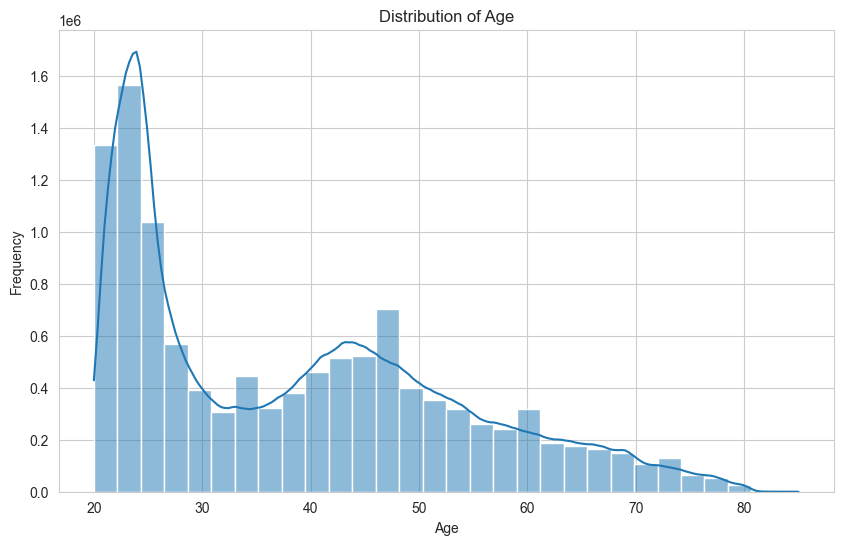

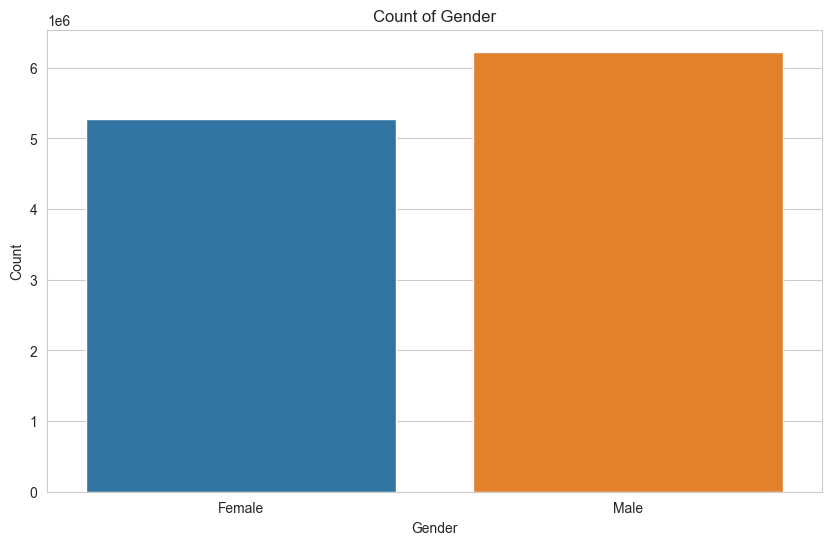

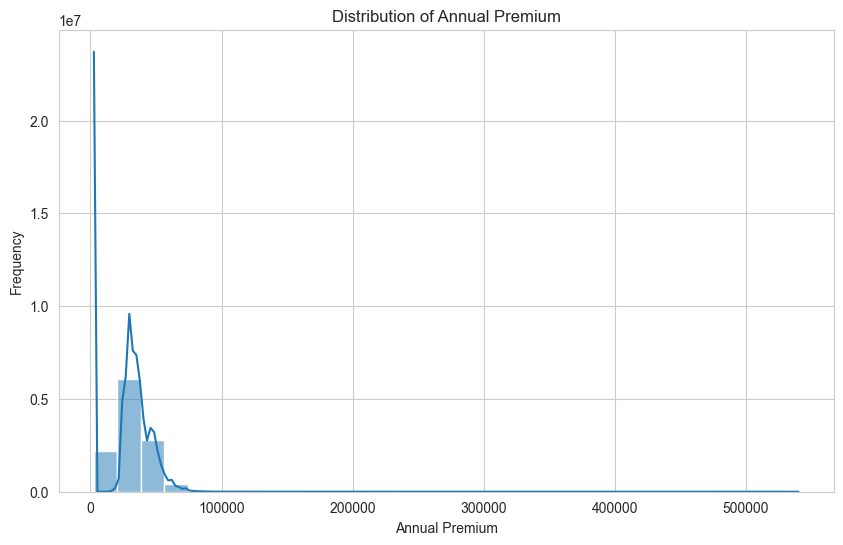

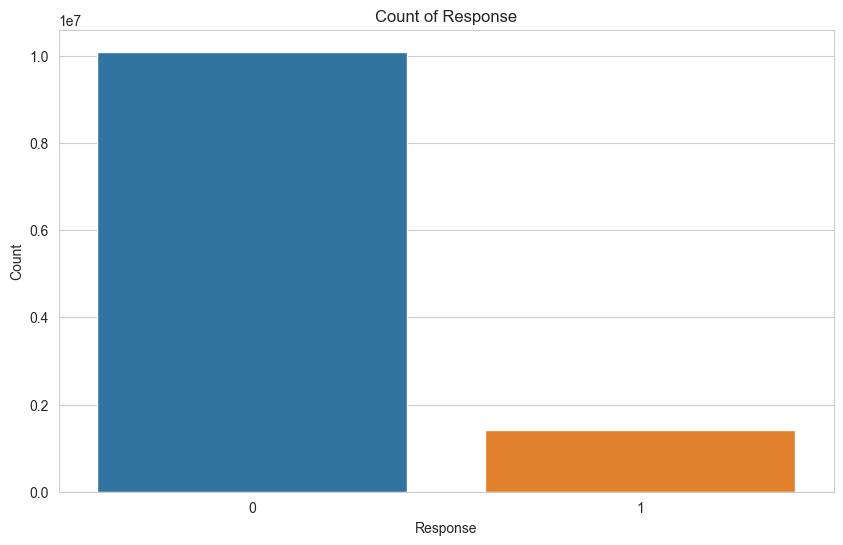

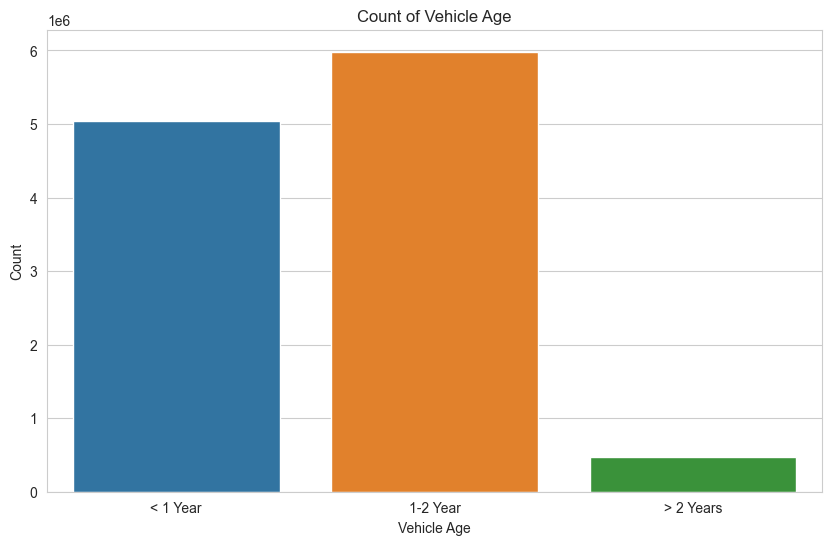

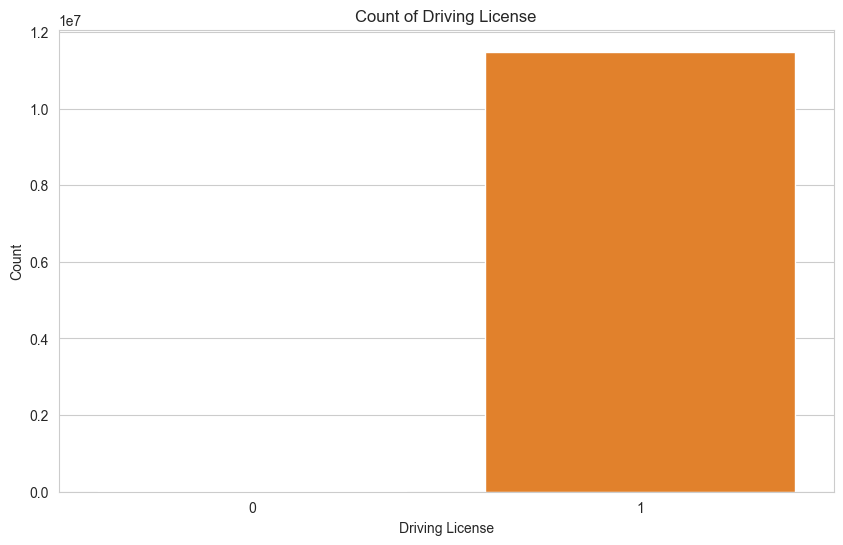

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot the distribution of 'Age'
plt.figure(figsize=(10, 6))
sns.histplot(train['Age'], bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Plot the count of 'Gender'
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', data=train)
plt.title('Count of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Plot the distribution of 'Annual_Premium'
plt.figure(figsize=(10, 6))
sns.histplot(train['Annual_Premium'], bins=30, kde=True)
plt.title('Distribution of Annual Premium')
plt.xlabel('Annual Premium')
plt.ylabel('Frequency')
plt.show()

# Plot the count of 'Response'
plt.figure(figsize=(10, 6))
sns.countplot(x='Response', data=train)
plt.title('Count of Response')
plt.xlabel('Response')
plt.ylabel('Count')
plt.show()

# Plot the count of 'Vehicle_Age'
plt.figure(figsize=(10, 6))
sns.countplot(x='Vehicle_Age', data=train)
plt.title('Count of Vehicle Age')
plt.xlabel('Vehicle Age')
plt.ylabel('Count')
plt.show()

# Plot the count of 'Driving_License'
plt.figure(figsize=(10, 6))
sns.countplot(x='Driving_License', data=train)
plt.title('Count of Driving License')
plt.xlabel('Driving License')
plt.ylabel('Count')
plt.show()


- Imbalance of Class Data -> '_Response_' column
    - **0** (Not Response): **10,089,739**
    - **1** (Response): **1,415,059**

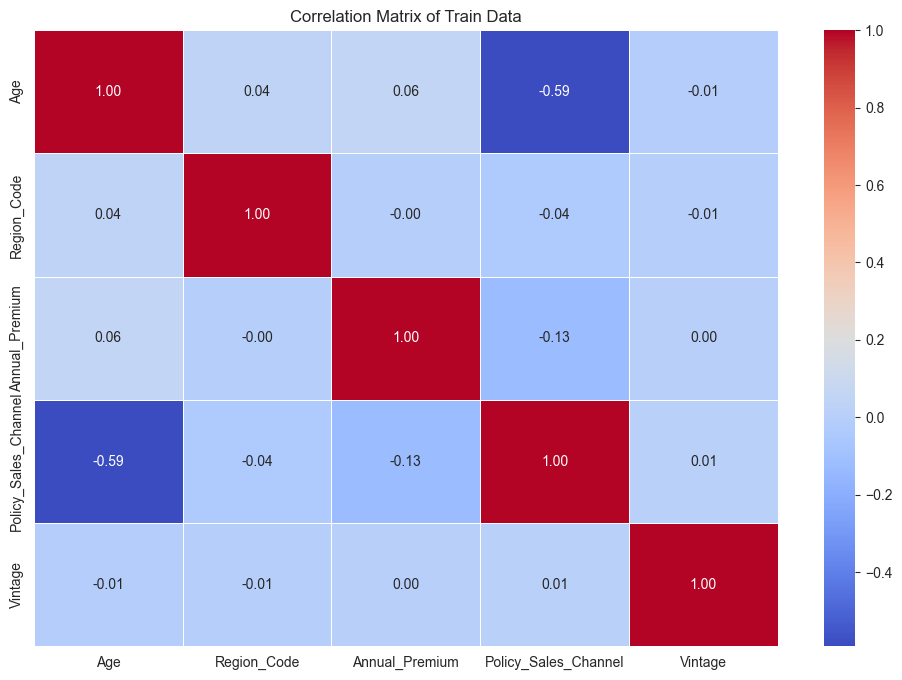

In [12]:
# 숫자(int, float) 타입이 아닌 컬럼을 제외하고 correlation matrix를 계산
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = train[numeric_columns].drop(columns=['id']).corr()

# 히트맵 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Train Data')
plt.show()

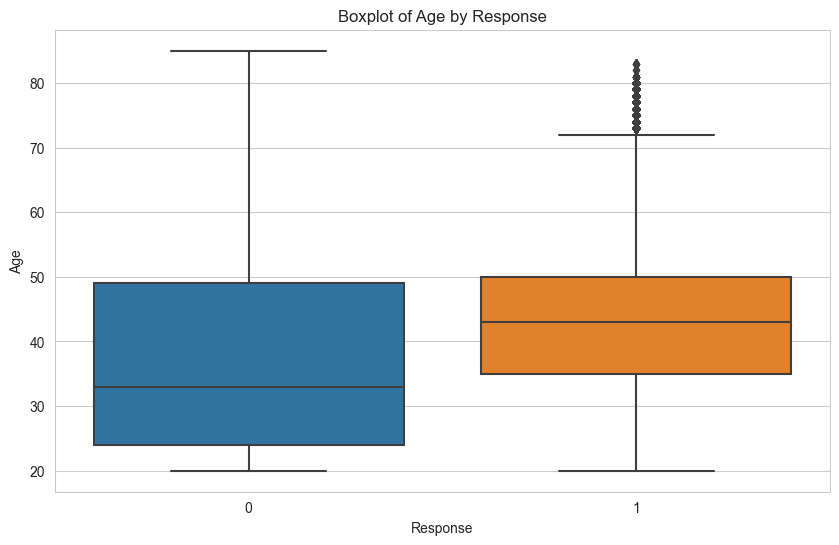

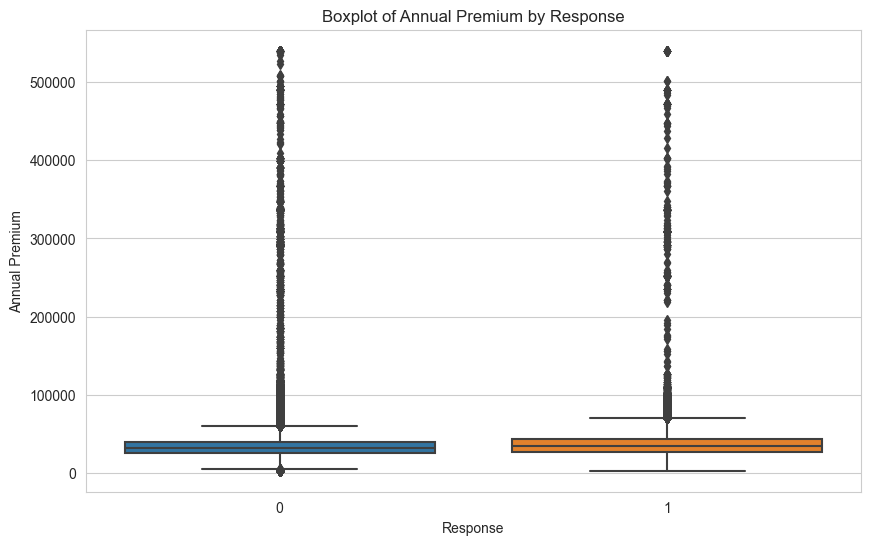

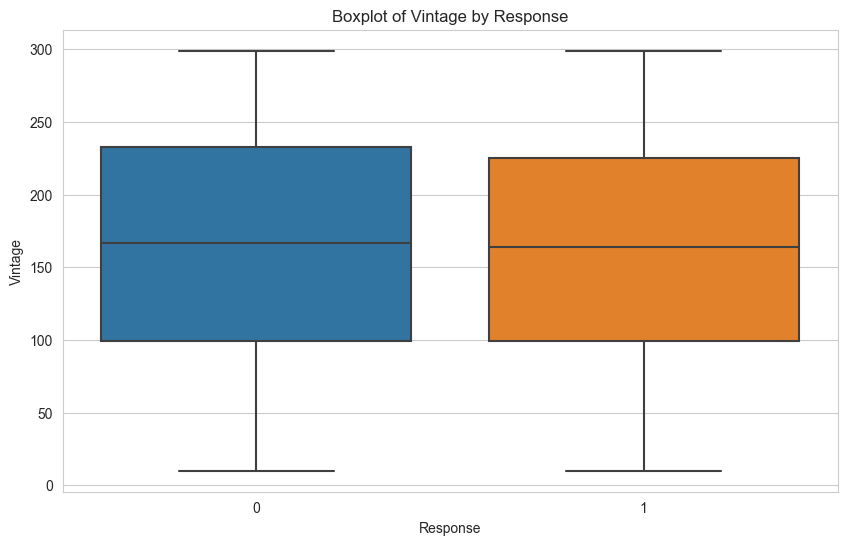

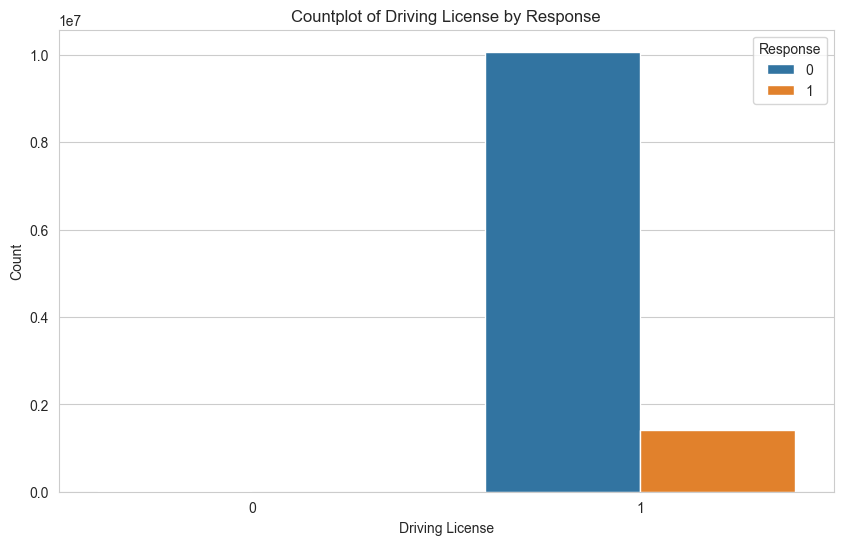

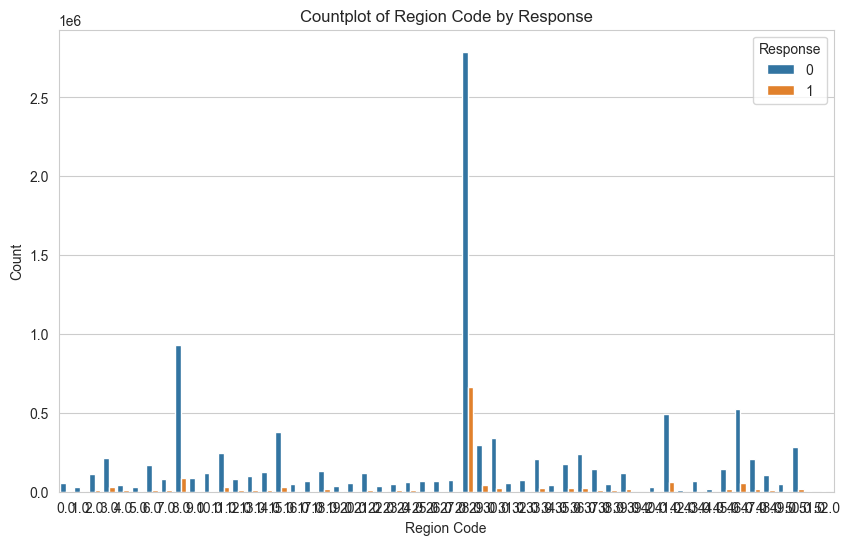

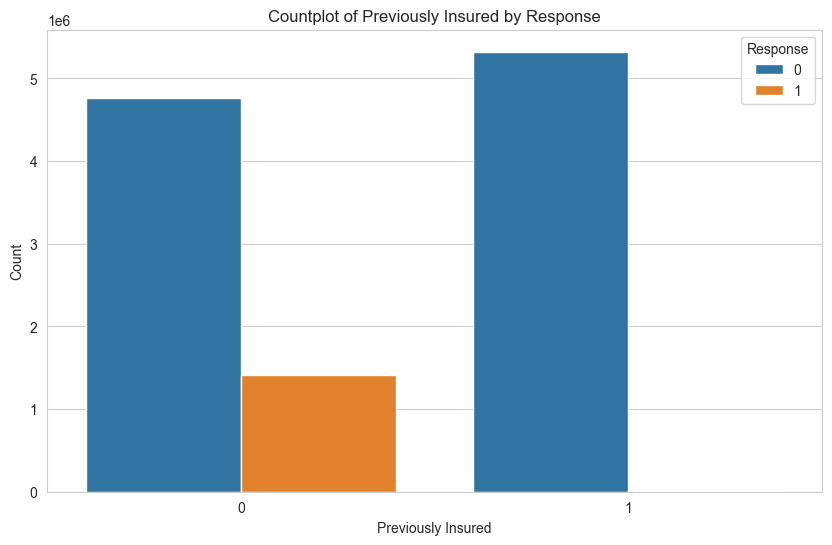

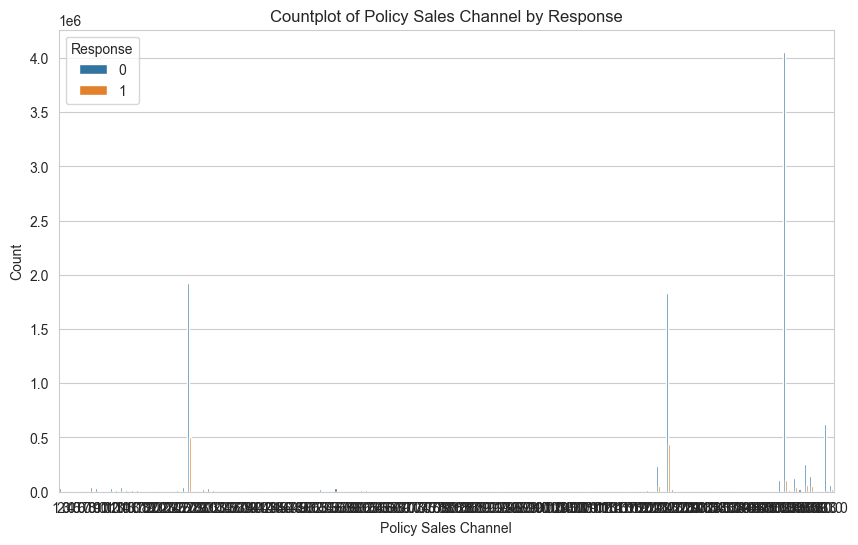

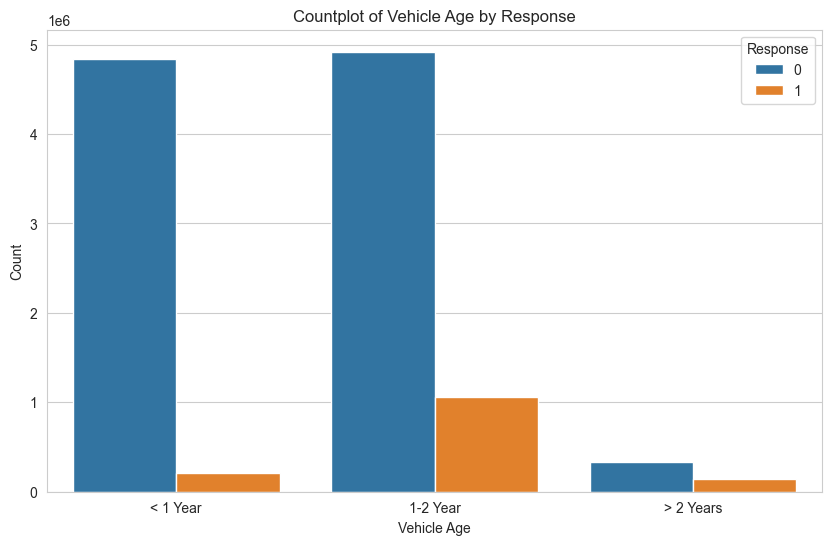

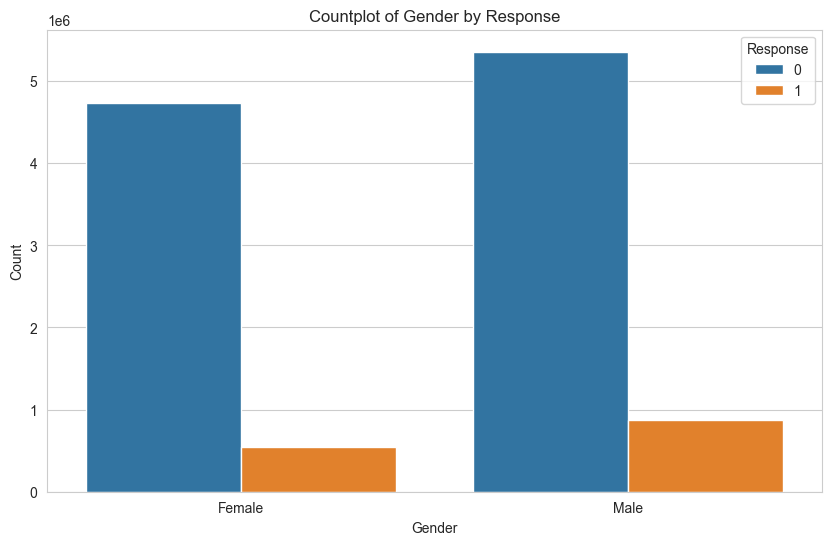

In [13]:
# 각 컬럼들의 Response 값에 따른 차이를 확인

# 'Age' 컬럼에 대한 boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Response', y='Age', data=train)
plt.title('Boxplot of Age by Response')
plt.xlabel('Response')
plt.ylabel('Age')
plt.show()

# 'Annual_Premium' 컬럼에 대한 boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Response', y='Annual_Premium', data=train)
plt.title('Boxplot of Annual Premium by Response')
plt.xlabel('Response')
plt.ylabel('Annual Premium')
plt.show()

# 'Vintage' 컬럼에 대한 boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Response', y='Vintage', data=train)
plt.title('Boxplot of Vintage by Response')
plt.xlabel('Response')
plt.ylabel('Vintage')
plt.show()

# 'Driving_License' 컬럼에 대한 countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Driving_License', hue='Response', data=train)
plt.title('Countplot of Driving License by Response')
plt.xlabel('Driving License')
plt.ylabel('Count')
plt.show()

# 'Region_Code' 컬럼에 대한 countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Region_Code', hue='Response', data=train)
plt.title('Countplot of Region Code by Response')
plt.xlabel('Region Code')
plt.ylabel('Count')
plt.show()

# 'Previously_Insured' 컬럼에 대한 countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Previously_Insured', hue='Response', data=train)
plt.title('Countplot of Previously Insured by Response')
plt.xlabel('Previously Insured')
plt.ylabel('Count')
plt.show()

# 'Policy_Sales_Channel' 컬럼에 대한 countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Policy_Sales_Channel', hue='Response', data=train)
plt.title('Countplot of Policy Sales Channel by Response')
plt.xlabel('Policy Sales Channel')
plt.ylabel('Count')
plt.show()

# 'Vehicle_Age' 컬럼에 대한 countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Vehicle_Age', hue='Response', data=train)
plt.title('Countplot of Vehicle Age by Response')
plt.xlabel('Vehicle Age')
plt.ylabel('Count')
plt.show()

# 'Gender' 컬럼에 대한 countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='Response', data=train)
plt.title('Countplot of Gender by Response')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()



In [12]:
# Gender에 따른 Response 차이를 비율로 확인
gender_response_counts = train.groupby(['Gender', 'Response'], observed=True).size().unstack()
gender_response_ratio = gender_response_counts.div(gender_response_counts.sum(axis=1), axis=0)
print(gender_response_ratio)


Response         0         1
Gender                      
Female    0.896703  0.103297
Male      0.860312  0.139688


In [15]:
# Driving License에 따른 Response 차이를 비율로 확인
driving_license_response_counts = train.groupby(['Driving_License', 'Response'], observed=True).size().unstack()
driving_license_response_ratio = driving_license_response_counts.div(driving_license_response_counts.sum(axis=1), axis=0)
print(driving_license_response_ratio)
print(train['Driving_License'].value_counts())


Response                0         1
Driving_License                    
0                0.944852  0.055148
1                0.876868  0.123132
Driving_License
1    11482041
0       22757
Name: count, dtype: int64


In [17]:
# Previously Insured에 따른 Response 차이를 비율로 확인
previously_insured_response_counts = train.groupby(['Previously_Insured', 'Response'], observed=True).size().unstack()
previously_insured_response_ratio = previously_insured_response_counts.div(previously_insured_response_counts.sum(axis=1), axis=0)
print(previously_insured_response_ratio)


Response                   0         1
Previously_Insured                    
0                   0.771507  0.228493
1                   0.999362  0.000638


[알게된 정보]
- Age가 높을 수록 Response가 1인 경우가 많음
    - 나이가 많을수록 보험에 대한 필요성이 커질 수 있으며, 반대로 젊은 층은 특정 금융 상품에 더 관심이 있을 수 있음
- Gender Response 비율: Female 0.10, Male 0.13
- Driving_License Response 비율: 0 0.05, 1 0.12
    - 운전면허 없는 사람이 극히 적음: 0 22757, 1 11482041
- Previously Insured가 1이면 Response가 1인 경우가 거의 없음
    - Response 비율: 0 0.2284, 1 0.0006
- Vehicle Age가 클 수록 Response 비율이 큼
    - Response 비율: < 1 Year 0.04, 1-2 Year 0.18, > Years 0.30

In [18]:
from scipy.stats import chi2_contingency, ttest_ind
# id와 response를 제외한 모든 컬럼에 대해서 response와의 유의미한 관계를 분석

# 분석할 컬럼 리스트
columns_to_analyze = [col for col in train.columns if col not in ['id', 'Response']]

# 각 컬럼에 대해 카이제곱 검정 수행
for column in columns_to_analyze:
    # 카테고리형 변수에 대해서만 카이제곱 검정 수행
    if train[column].dtype == 'object' or len(train[column].unique()) < 10:
        contingency_table = pd.crosstab(train[column], train['Response'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        print(f'{column} - Chi2: {chi2}, p-value: {p}')
    else:
        # 연속형 변수에 대해서는 t-test 수행
        group0 = train[train['Response'] == 0][column]
        group1 = train[train['Response'] == 1][column]
        t_stat, p_val = ttest_ind(group0, group1)
        print(f'{column} - t-statistic: {t_stat}, p-value: {p_val}')


Gender - Chi2: 35070.87159196822, p-value: 0.0
Age - t-statistic: -417.38670662865786, p-value: 0.0
Driving_License - Chi2: 972.499672088707, p-value: 1.7058045796900096e-213
Region_Code - t-statistic: -43.47490174888443, p-value: 0.0
Previously_Insured - Chi2: 1376747.7298044744, p-value: 0.0
Vehicle_Age - Chi2: 614768.2061375531, p-value: 0.0
Vehicle_Damage - Chi2: 1489196.3454699982, p-value: 0.0
Annual_Premium - t-statistic: -109.4810491742203, p-value: 0.0
Policy_Sales_Channel - t-statistic: 524.2004036306735, p-value: 0.0
Vintage - t-statistic: 51.48342314376964, p-value: 0.0


In [30]:
# 데이터프레임 복사
df = train.copy()

# 데이터 타입 변환
df['Region_Code'] = df['Region_Code'].astype(int)
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype(int)

# Vehicle_Damage 변환: Yes -> 1, No -> 0
df['Vehicle_Damage'] = df['Vehicle_Damage'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)
df['Previously_Insured'] = df['Previously_Insured'].astype(int)

# 1. Insured_Vintage: Previously_Insured와 Vintage의 곱
df['Insured_Vintage'] = df['Previously_Insured'] * df['Vintage']

# 2. Region_Risk: 각 Region_Code 별 평균 Vehicle_Damage 비율
region_risk = df.groupby('Region_Code')['Vehicle_Damage'].mean()
df['Region_Risk'] = df['Region_Code'].map(region_risk)


In [31]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Insured_Vintage,Region_Risk
0,0,Male,21,1,35,0,1-2 Year,1,65101.0,124,187,0,0,0.419157
1,1,Male,43,1,28,0,> 2 Years,1,58911.0,26,288,1,0,0.660843
2,2,Female,25,1,14,1,< 1 Year,0,38043.0,152,254,0,254,0.349987
3,3,Female,35,1,1,0,1-2 Year,1,2630.0,156,76,0,0,0.603780
4,4,Female,36,1,15,1,1-2 Year,0,31951.0,152,294,0,294,0.435384


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 14 columns):
 #   Column                Dtype   
---  ------                -----   
 0   id                    int64   
 1   Gender                category
 2   Age                   int64   
 3   Driving_License       category
 4   Region_Code           int32   
 5   Previously_Insured    int32   
 6   Vehicle_Age           category
 7   Vehicle_Damage        int32   
 8   Annual_Premium        float64 
 9   Policy_Sales_Channel  int32   
 10  Vintage               int64   
 11  Response              category
 12  Insured_Vintage       int64   
 13  Region_Risk           float64 
dtypes: category(4), float64(2), int32(4), int64(4)
memory usage: 746.1 MB


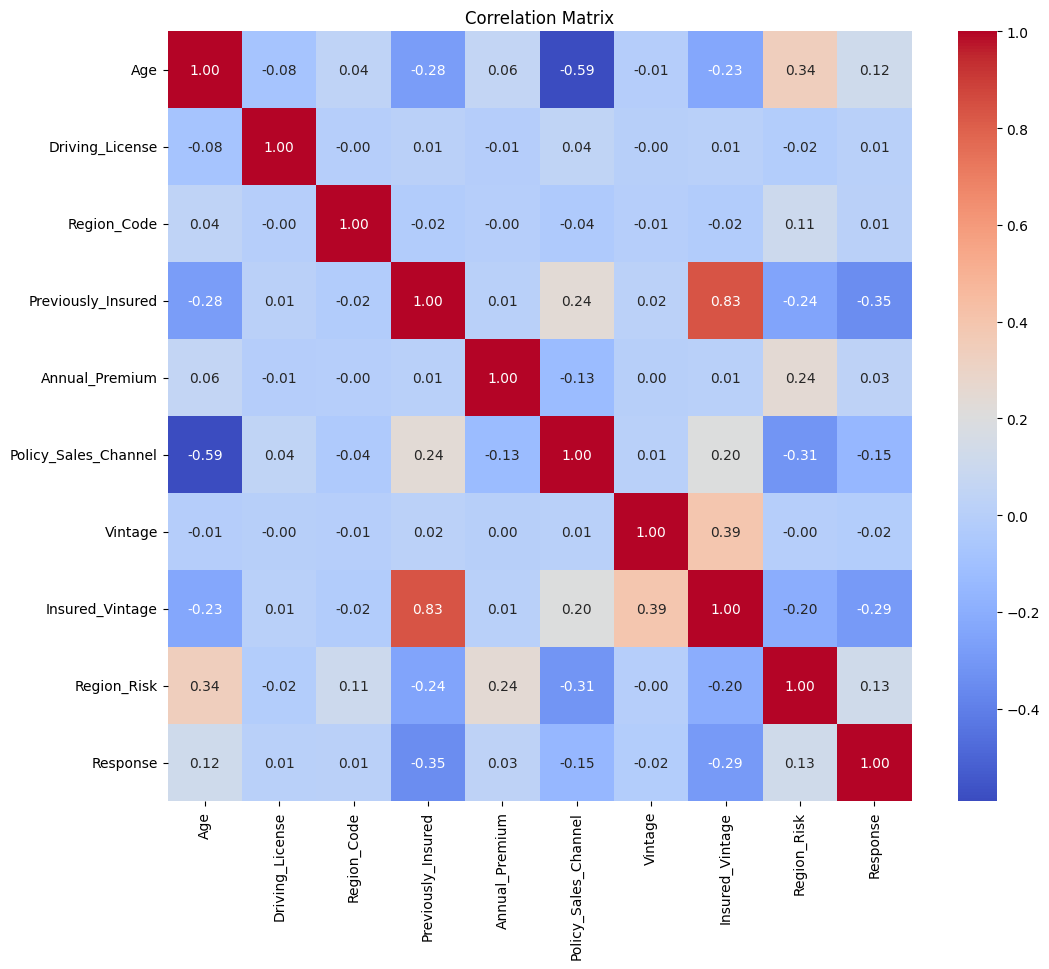

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터프레임 복사
df1 = df.copy()

# 필요한 변수 선택
variables = ['Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Annual_Premium',
             'Policy_Sales_Channel', 'Vintage', 'Insured_Vintage', 'Region_Risk', 'Response']

# 상관계수 행렬 계산
correlation_matrix = df1[variables].corr()

# 상관계수 행렬 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [35]:
df2 = df1.copy()
df2 = df2.drop(columns=['Previously_Insured'])

In [ ]:
df2.head()

# Preprocessing

## Data Load

In [4]:
train = pd.DataFrame(pd.read_csv("data\\train.csv"))
test = pd.DataFrame(pd.read_csv("data\\test.csv"))

## Make Derived Variables for Train

In [12]:
# Train 데이터프레임 파생변수 만들기
df = derived_variables(train)

In [13]:
df.head()

,Gender,Age,Driving_License,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Insured_Vintage,Region_Risk
0,Male,21,1,1-2 Year,1,65101.0,124,187,0,0,0.419157
1,Male,43,1,> 2 Years,1,58911.0,26,288,1,0,0.660843
2,Female,25,1,< 1 Year,0,38043.0,152,254,0,254,0.349987
3,Female,35,1,1-2 Year,1,2630.0,156,76,0,0,0.603780
4,Female,36,1,1-2 Year,0,31951.0,152,294,0,294,0.435384


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype   
---  ------                -----   
 0   Gender                category
 1   Age                   int64   
 2   Driving_License       category
 3   Vehicle_Age           category
 4   Vehicle_Damage        int32   
 5   Annual_Premium        float64 
 6   Policy_Sales_Channel  int32   
 7   Vintage               int64   
 8   Response              category
 9   Insured_Vintage       int64   
 10  Region_Risk           float64 
dtypes: category(4), float64(2), int32(2), int64(3)
memory usage: 570.5 MB


## Normalization of train & Save stats for normalization of test

In [15]:
train_norm, stats = normalize_train_data(df)

In [16]:
train_norm.head()

,Gender,Age,Driving_License,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Insured_Vintage,Region_Risk
0,Male,-1.159410,1,1-2 Year,1,2.105145,0.214202,0.288852,0,-0.774741,-0.682735
1,Male,0.307897,1,> 2 Years,1,1.728962,-1.599414,1.551675,1,-0.774741,1.292861
2,Female,-0.892627,1,< 1 Year,0,0.460756,0.732378,1.126566,0,1.792265,-1.248142
3,Female,-0.225669,1,1-2 Year,1,-1.691389,0.806403,-1.099003,0,-0.774741,0.826417
4,Female,-0.158974,1,1-2 Year,0,0.090529,0.732378,1.626694,0,2.196517,-0.550092


In [17]:
train_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype   
---  ------                -----   
 0   Gender                category
 1   Age                   float64 
 2   Driving_License       object  
 3   Vehicle_Age           category
 4   Vehicle_Damage        object  
 5   Annual_Premium        float64 
 6   Policy_Sales_Channel  float64 
 7   Vintage               float64 
 8   Response              object  
 9   Insured_Vintage       float64 
 10  Region_Risk           float64 
dtypes: category(2), float64(6), object(3)
memory usage: 811.9+ MB


In [18]:
stats

{'Age': (38.38356336199905, 14.993458508381062),
 'Annual_Premium': (30461.370410588694, 16454.74520506136),
 'Policy_Sales_Channel': (112.42544188954903, 54.03570777686181),
 'Vintage': (163.89774388042275, 79.97953110341109),
 'Insured_Vintage': (76.65902243568293, 98.94798809469343),
 'Region_Risk': (0.5026797515262756, 0.12233599691893907)}

## One Hot encoding

In [19]:
train_encoded = one_hot_encode(train_norm)

In [20]:
train_encoded.head()

,Age,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Insured_Vintage,Region_Risk,Gender_Male,Driving_License_1,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_1
0,-1.159410,2.105145,0.214202,0.288852,0,-0.774741,-0.682735,True,True,False,False,True
1,0.307897,1.728962,-1.599414,1.551675,1,-0.774741,1.292861,True,True,False,True,True
2,-0.892627,0.460756,0.732378,1.126566,0,1.792265,-1.248142,False,True,True,False,False
3,-0.225669,-1.691389,0.806403,-1.099003,0,-0.774741,0.826417,False,True,False,False,True
4,-0.158974,0.090529,0.732378,1.626694,0,2.196517,-0.550092,False,True,False,False,False


## Convert bool type to numeric

In [21]:
train_continous = convert_bool_to_numeric(train_encoded)

In [22]:
train_continous.head()

,Age,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Insured_Vintage,Region_Risk,Gender_Male,Driving_License_1,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_1
0,-1.159410,2.105145,0.214202,0.288852,0,-0.774741,-0.682735,1,1,0,0,1
1,0.307897,1.728962,-1.599414,1.551675,1,-0.774741,1.292861,1,1,0,1,1
2,-0.892627,0.460756,0.732378,1.126566,0,1.792265,-1.248142,0,1,1,0,0
3,-0.225669,-1.691389,0.806403,-1.099003,0,-0.774741,0.826417,0,1,0,0,1
4,-0.158974,0.090529,0.732378,1.626694,0,2.196517,-0.550092,0,1,0,0,0


## Save Preprocessed data

In [23]:
import pickle
train_continous.to_csv('data/train_preprocessed.csv', index=None)
with open('data/stats.pickle', 'wb') as file:
    pickle.dump(stats, file)

KeyboardInterrupt: 